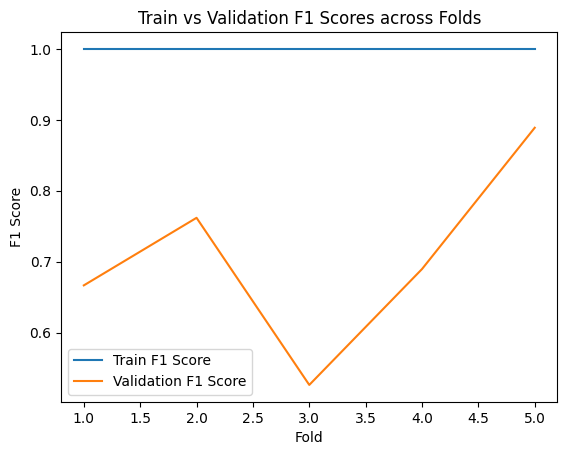

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.56      0.62      0.59         8

    accuracy                           0.68        22
   macro avg       0.66      0.67      0.66        22
weighted avg       0.69      0.68      0.69        22



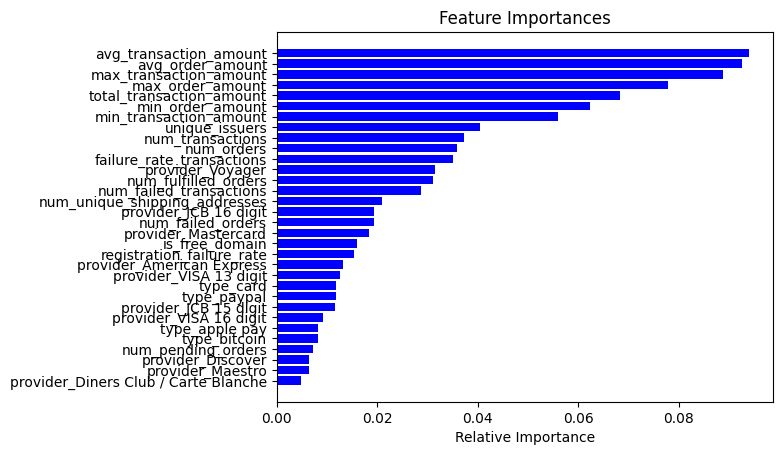

In [9]:

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Load the data

data = pd.read_csv('../prepared_data_files/processed_customers.csv')
data = data.drop(['countryIP','countryCodeIP','latIP','lonIP','latBillingAddress','lonBillingAddress','geo_distance'], axis=1)

# Prepare X and y
X = data.drop('fraudulent', axis=1)
y = data['fraudulent']

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Random Forest with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Manually iterating over the folds
kf = StratifiedKFold(n_splits=5)
train_f1_scores = []
val_f1_scores = []

for train_index, val_index in kf.split(X_train_smote, y_train_smote):
    X_train_fold, X_val_fold = X_train_smote[train_index], X_train_smote[val_index]
    y_train_fold, y_val_fold = y_train_smote[train_index], y_train_smote[val_index]

    best_rf = grid_search.best_estimator_
    best_rf.fit(X_train_fold, y_train_fold)

    train_f1_scores.append(f1_score(y_train_fold, best_rf.predict(X_train_fold)))
    val_f1_scores.append(f1_score(y_val_fold, best_rf.predict(X_val_fold)))

# Plotting the F1 scores
plt.plot(range(1, 6), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, 6), val_f1_scores, label='Validation F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Train vs Validation F1 Scores across Folds')
plt.legend()
plt.show()

# Adjust Decision Threshold
best_rf = grid_search.best_estimator_
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_prob >= 0.4).astype(int)
print(classification_report(y_test, y_pred_adjusted))

# Feature Importance Graph
importances = best_rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



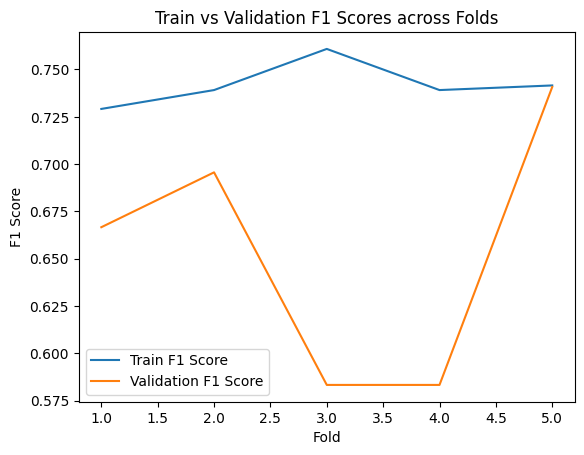

              precision    recall  f1-score   support

           0       1.00      0.21      0.35        14
           1       0.42      1.00      0.59         8

    accuracy                           0.50        22
   macro avg       0.71      0.61      0.47        22
weighted avg       0.79      0.50      0.44        22



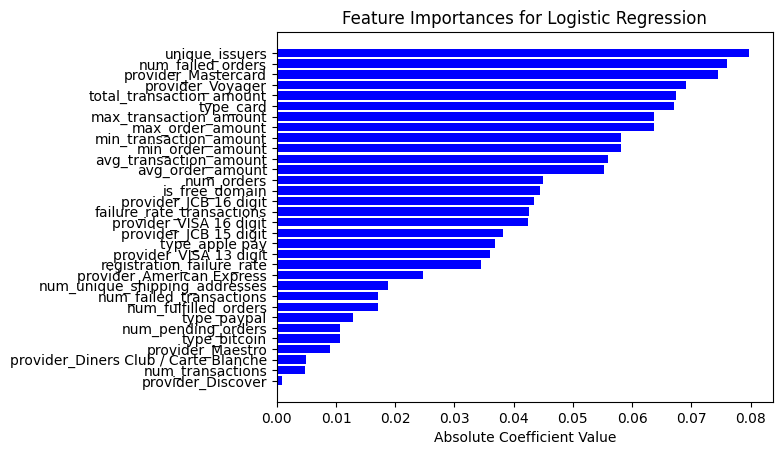

In [10]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of penalty
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

lr = LogisticRegression(random_state=42, max_iter=10000)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Manually iterating over the folds
kf = StratifiedKFold(n_splits=5)
train_f1_scores = []
val_f1_scores = []

for train_index, val_index in kf.split(X_train_smote, y_train_smote):
    X_train_fold, X_val_fold = X_train_smote[train_index], X_train_smote[val_index]
    y_train_fold, y_val_fold = y_train_smote[train_index], y_train_smote[val_index]

    best_lr = grid_search.best_estimator_
    best_lr.fit(X_train_fold, y_train_fold)

    train_f1_scores.append(f1_score(y_train_fold, best_lr.predict(X_train_fold)))
    val_f1_scores.append(f1_score(y_val_fold, best_lr.predict(X_val_fold)))

# Plotting the F1 scores
plt.plot(range(1, 6), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, 6), val_f1_scores, label='Validation F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Train vs Validation F1 Scores across Folds')
plt.legend()
plt.show()

# Adjust Decision Threshold
best_lr = grid_search.best_estimator_
y_pred_prob = best_lr.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_prob >= 0.4).astype(int)
print(classification_report(y_test, y_pred_adjusted))

# Feature Importance Graph for Logistic Regression
# For Logistic Regression, we can use the coefficients as feature importance.
importance = np.abs(best_lr.coef_[0])
indices = np.argsort(importance)
plt.title('Feature Importances for Logistic Regression')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Absolute Coefficient Value')
plt.show()

When choosing between models for a fraud detection algorithm, it's crucial to consider the context and cost of different types of errors. False positives (legitimate transactions flagged as fraudulent) can be an inconvenience, whereas false negatives (fraudulent transactions not detected) can have a significant financial impact. In fraud detection, recall (sensitivity) is often prioritized because failing to detect fraud is usually more costly than incorrectly flagging a legitimate transaction. That's why in both models we set the decision threshold at 0.4.

### <b> Random Forest Model</b>

- <b>Classification Report:</b> The Random Forest model shows a balanced performance with respect to precision and recall for both classes. The F1 scores are relatively close, with 0.74 for the non-fraudulent class and 0.59 for the fraudulent class. This suggests a reasonable trade-off between precision and recall.
- <b>F1 Score Graph:</b> The training F1 scores are consistently high, which is typical for Random Forest due to its complexity and ability to capture nuances in the training data. The validation scores fluctuate but are within a reasonable range, suggesting the model is not drastically overfitting.

### <b> Logistic Regression  Model</b>

- <b>Classification Report:</b> The Logistic Regression model has a high precision for the non-fraudulent class but very low recall, meaning it fails to identify a substantial number of fraudulent cases. Conversely, it identifies most fraudulent cases (high recall) but has low precision, meaning it flags many legitimate transactions as fraudulent.
- <b>F1 Score Graph:</b> The graph shows a significant difference between training and validation F1 scores, with validation scores being much lower. This could indicate the model is overfitting or not generalizing well.



### Decision

Considering the classification reports:

- Random Forest shows a better balance of precision and recall, which is desirable in a fraud detection scenario. The accuracy and macro-average F1 score are higher than those of Logistic Regression. This model seems to offer a more balanced approach to differentiating between fraudulent and non-fraudulent transactions.
- Logistic Regression shows a concerning pattern in the precision-recall trade-off. While it is very good at identifying fraudulent transactions (high recall for class 1), it does so at the expense of incorrectly labeling many non-fraudulent transactions as fraud (low precision for class 1). This could potentially lead to many false alarms, which may not be ideal in a user-facing fraud detection system.


Given the above analysis and assuming the cost of false negatives is higher than false positives in this scenario, the Random Forest model is the better choice. It has a more balanced performance and seems to generalize better according to the F1 scores across folds. The Logistic Regression model, despite a potentially higher overall recall, would likely cause too many false positives due to its low precision, leading to many legitimate transactions being flagged as fraudulent. This could be detrimental to user experience and operational efficiency.

### Feature importance for Random Forest

The feature importance graph represents the relative importance of different features as determined by the Random Forest model. Features at the top of the graph are deemed most important, while those at the bottom have the least importance in terms of predicting the target variable, which in our case is the likelihood of fraudulent activity.

In this graph, the most important feature is avg_transaction_amount, indicating that the average amount of a transaction is the strongest predictor of fraud according to this model. This could mean that fraudulent transactions have a distinct average amount compared to legitimate ones. The next two important features are related to the order amount (avg_order_amount and max_transaction_amount), which suggests that the size of the order is also significant in predicting fraudulent activity.

Less important features, which are at the bottom of the graph, like provider_Diners Club / Carte Blanche, provider_Discover, and various payment types like type_apple pay, have very small bars indicating they contribute less to the model's decisions. This lower importance could be due to a lower frequency of these features in the dataset or a weaker relationship with fraudulent behavior.

The graph gives insight into which variables might warrant closer inspection for fraud prevention measures. The high importance of transaction amounts suggests focusing on abnormal transaction sizes could be an effective strategy for identifying fraud. However, it's also important to consider the model in a broader context, as other factors not represented in the data might also be important, and the relative importances are specific to this model and dataset.